# Concept Activation Vectors (CAVs) example on CIFAR data
### Peter Xenopoulos

In this workbook, we will go over how to use concept activation vectors (CAVs) on some popular image data -- the CIFAR datasets. These datasets are available through the `keras` package. 

For our first experiment, we will build a classifier that distinguishes between "ship" and "bird" images from CIFAR-10. We start by calling the necessary libraries and data.

In [27]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10152301405482740333, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 231048778863343563
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10593743193011152494
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11075395165991583517
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import zipfile
with zipfile.ZipFile("/content/cav-keras-master.zip","r") as zip_ref:
    zip_ref.extractall()

In [4]:
%cd /content/cav-keras-master/

/content/cav-keras-master


In [6]:
!pip3 install -r requirements.txt

In [7]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *

np.random.seed(1996)

Using TensorFlow backend.


In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep ships (8) from CIFAR-10
interested_class = y_train == [8]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 10s 0us/step


We can see two examples images below. This is a fairly easy classification problem.

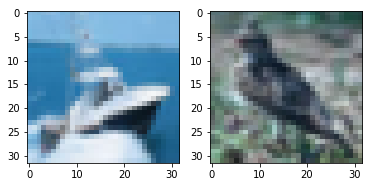

In [9]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

Now, let's say we are interested in how sensitive each class is to the concept of the "ocean". Clearly, the ship class, which we designate as 1, will likely be more sensitive. 

In [10]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (71) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]

169009152/169001437 [==============================] - 8s 0us/step


Finally, we train and summarize our model. This is the standard classifier that the Keras team provides for CIFAR-10.

In [11]:
batch_size = 32
epochs = 5

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10000/10000 [==============================] - 8s 795us/step - loss: 0.3491 - acc: 0.8462
Epoch 2/5
10000/10000 [==============================] - 2s 207us/step - loss: 0.2123 - acc: 0.9170
Epoch 3/5
10000/10000 [==============================] - 2s 206us/step - loss: 0.1830 - acc: 0.9308
Epoch 4/5
10000/10000 [==============================] - 2s 207us/step - loss: 0.1684 - acc: 0.9359
Epoch 5/5
10000/10000 [==============================] - 2s 207us/step - loss: 0.1420 - acc: 0.9491


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Now, we instantiate the `TCAV` object. The first thing one should do when using `TCAV` is assign it a model. There are two ways to do this: (1) use the `.set_model(model)` method OR (2) create a `TCAV` object using `TCAV(model = model)`. Please note that `model` should be a Keras sequential model. We provide an example below.

In [0]:
tcav_obj = TCAV()
tcav_obj.set_model(model)

Next, we must specify the "bottleneck" layer, and if that layer is a convolutional layer. One can split the model in the object through the `.split_model(bottleneck, conv_layer)` method. Please note that you should split on the last activation/pooling/dropout layer. So, we can split on layers 1, 5, 7 and 11 (starting counting from 0).

One the model has been split on the specified bottleneck layer, one must train the concept activation vector. This is done through the `.train_cav(x_concept)` method, which is passed the concept training data. In our case, this is the numpy array of sea images from CIFAR-100. The TCAV object takes care of creating counterexamples.

Next, we calculate the sensitivities for our training data through the `.calculate_sensitivity(x_train, y_labels)` method. This method saves the sensitivities for each training object in the `Object.sensitivity` attribute. 

Finally, to print the sensitivities, simply use the `.print_sensitivity()` method.

In [15]:
tcav_obj.split_model(bottleneck = 1, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.926
The sensitivity of class 0 is  0.0122


In [16]:
tcav_obj.split_model(bottleneck = 5, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.9154
The sensitivity of class 0 is  0.0408


In [17]:
tcav_obj.split_model(bottleneck = 7, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.4064
The sensitivity of class 0 is  0.0564


In [18]:
tcav_obj.split_model(bottleneck = 11, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.0442
The sensitivity of class 0 is  0.9904


Above, we clearly see that the sea is a strong concept for class 1, which is the ship. Interestingly, the last layer gives a strong sensitivity to class 0, birds.

Next, we can use another example, which uses airplanes and birds. Our concept will be "clouds".

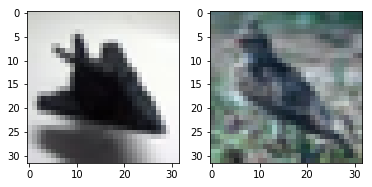

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes from CIFAR-10
interested_class = y_train == [0]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

In [0]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep cloud (23) from CIFAR-100
concept = y_train_concept == [23]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]

In [21]:
# Set parameters
batch_size = 32
epochs = 5

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/5
10000/10000 [==============================] - 3s 285us/step - loss: 0.4640 - acc: 0.7808
Epoch 2/5
10000/10000 [==============================] - 2s 210us/step - loss: 0.3602 - acc: 0.8457
Epoch 3/5
10000/10000 [==============================] - 2s 210us/step - loss: 0.3225 - acc: 0.8617
Epoch 4/5
10000/10000 [==============================] - 2s 210us/step - loss: 0.3017 - acc: 0.8730
Epoch 5/5
10000/10000 [==============================] - 2s 209us/step - loss: 0.2697 - acc: 0.8878


In [0]:
tcav_obj = TCAV()
tcav_obj.set_model(model)

In [23]:
tcav_obj.split_model(bottleneck = 1, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.7222
The sensitivity of class 0 is  0.592


In [24]:
tcav_obj.split_model(bottleneck = 5, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.8808
The sensitivity of class 0 is  0.3584


In [25]:
tcav_obj.split_model(bottleneck = 7, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.5176
The sensitivity of class 0 is  0.0106


In [26]:
tcav_obj.split_model(bottleneck = 11, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  1.0
The sensitivity of class 0 is  0.0


We can see that airplanes do have a high sensitivity to the "cloud" concept, as do birds in the early layers.